# Arbitrage and Pair trading strategy function definitions

## Step 1: Import Required Libraries

In this step, we will import essential Python libraries for:
- Data handling (`pandas`, `numpy`)
- Statistical analysis (`statsmodels`)
- Visualization (`matplotlib`, `seaborn`)
- Backtesting (`backtrader`)

In [34]:
# Importing required libraries
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from statsmodels.tsa.stattools import coint

# Set plotting style
sns.set_style("whitegrid")

## Step 2: Fetch Historical Stock Data

We'll use Yahoo Finance API to download historical price data for two stocks.
For demonstration, we'll select **Goldman Sachs (GS)** and **Morgan Stanley (MS)**,
as they are often found to be highly correlated.

In [35]:
# Define stock tickers
stock_1 = "GS"  # Goldman Sachs
stock_2 = "MS"  # Morgan Stanley

# Define time period
start_date = "2020-01-01"
end_date = "2024-01-01"

# Fetch data from Yahoo Finance
df1 = yf.download(stock_1, start=start_date, end=end_date)["Close"]
df2 = yf.download(stock_2, start=start_date, end=end_date)["Close"]

# Convert df1 and df2 to Series explicitly if they are DataFrames
df1 = df1.squeeze()  # Convert to Series if it's a DataFrame
df2 = df2.squeeze()  # Convert to Series if it's a DataFrame

# Combine into a DataFrame
data = pd.DataFrame({stock_1: df1, stock_2: df2}, index=df1.index)

# Display first few rows
data.head()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,GS,MS
Date,,
2020-01-02,206.306183,43.983032
2020-01-03,203.893799,43.273083
2020-01-06,205.980423,43.120953
2020-01-07,207.336319,43.036434
2020-01-08,209.334915,43.585804


## Step 3: Perform Cointegration Test

A key step in Pairs Trading is to check whether two stocks are **cointegrated**.
Cointegration ensures that the spread between the two assets reverts to a mean,
making it suitable for trading.

We will use the **Engle-Granger Cointegration Test** from `statsmodels` library.

In [36]:
# Perform the Engle-Granger cointegration test
score, p_value, _ = coint(data[stock_1], data[stock_2])

# Display results
print(f"Cointegration Test p-value: {p_value:.4f}")

# If p-value < 0.05, the pair is cointegrated
if p_value < 0.05:
    print("The two stocks are cointegrated. Suitable for Pairs Trading!")
else:
    print("The stocks are NOT cointegrated. Consider finding another pair.")

Cointegration Test p-value: 0.0681
The stocks are NOT cointegrated. Consider finding another pair.


## Step 4: Calculate the Spread & Z-Score

The **spread** between the two assets is calculated as:
\[
\text{Spread} = \text{Stock 1} - \beta \times \text{Stock 2}
\]
where **β (hedge ratio)** is obtained from an **Ordinary Least Squares (OLS) regression**.

We then normalize the spread using a **Z-score transformation**:
\[
Z = \frac{\text{Spread} - \mu}{\sigma}
\]
where **μ** is the mean and **σ** is the standard deviation of the spread.


In [37]:
# Perform linear regression to get hedge ratio
X = sm.add_constant(data[stock_2])  # Add constant for intercept
model = sm.OLS(data[stock_1], X).fit()
hedge_ratio = model.params[1]  # Extract β coefficient

# Calculate spread
data["Spread"] = data[stock_1] - hedge_ratio * data[stock_2]

# Compute Z-score
data["Spread_Mean"] = data["Spread"].rolling(window=50).mean()
data["Spread_Std"] = data["Spread"].rolling(window=50).std()
data["Z-Score"] = (data["Spread"] - data["Spread_Mean"]) / data["Spread_Std"]

# Display last few rows
data.tail()

<ipython-input-37-ca61c69942dc>:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hedge_ratio = model.params[1]  # Extract β coefficient


,GS,MS,Spread,Spread_Mean,Spread_Std,Z-Score
Date,,,,,,
2023-12-22,369.813416,88.572929,54.795516,53.709721,7.949319,0.136590
2023-12-26,370.746094,88.985069,54.262380,54.073579,7.530751,0.025071
2023-12-27,373.534393,89.771027,54.255349,54.402515,7.155662,-0.020566
2023-12-28,375.409424,89.751846,56.198596,54.975023,6.020365,0.203239
2023-12-29,374.787659,89.378044,56.906293,55.337215,5.553868,0.282520


## Step 5: Define Trading Signals

We will create a **long-short trading strategy**:
- **Go Long (Buy Spread):** When Z-score < -2
- **Go Short (Sell Spread):** When Z-score > +2
- **Exit Positions:** When Z-score reverts to 0

In [38]:
# Define trading signals
data["Long"] = data["Z-Score"] < -2  # Buy the spread
data["Short"] = data["Z-Score"] > 2   # Sell the spread
data["Exit"] = abs(data["Z-Score"]) < 0.5  # Close position when Z-score near zero

# Show the signals
data[["Z-Score", "Long", "Short", "Exit"]].tail()

,Z-Score,Long,Short,Exit
Date,,,,
2023-12-22,0.136590,False,False,True
2023-12-26,0.025071,False,False,True
2023-12-27,-0.020566,False,False,True
2023-12-28,0.203239,False,False,True
2023-12-29,0.282520,False,False,True


## Step 6: Backtest the Pairs Trading Strategy

We will simulate the **cumulative returns** of the strategy assuming:
- Each trade is made with **equal capital allocation**.
- Trading occurs when **entry conditions** are met.
- Position is closed when **exit condition** is triggered.


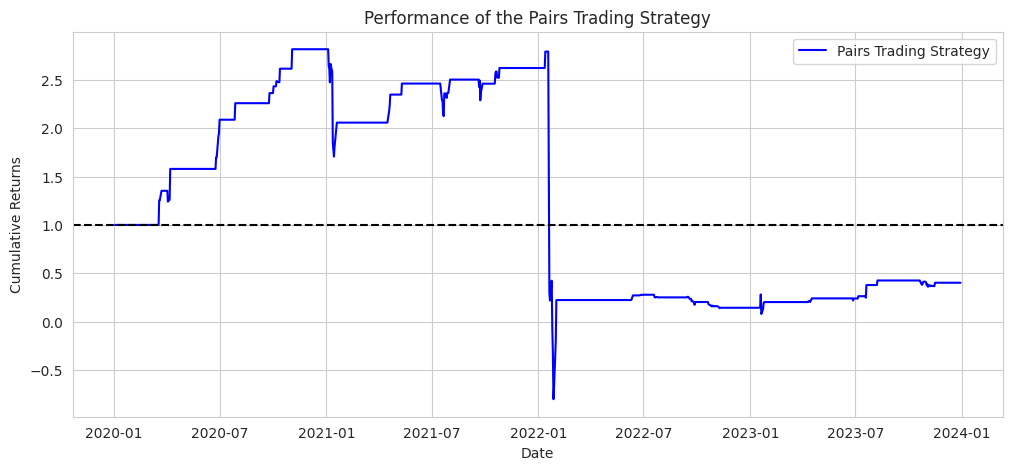

In [39]:
# Create a position column
data["Position"] = 0  # Default no position
data.loc[data["Long"], "Position"] = 1  # Long spread
data.loc[data["Short"], "Position"] = -1  # Short spread
data.loc[data["Exit"], "Position"] = 0  # Exit position

# Calculate daily returns
data["Returns"] = data["Position"].shift(1) * data["Spread"].pct_change()

# Compute cumulative returns
data["Cumulative Returns"] = (1 + data["Returns"]).cumprod()

# Plot the strategy's performance
plt.figure(figsize=(12, 5))
plt.plot(data.index, data["Cumulative Returns"], label="Pairs Trading Strategy", color="blue")
plt.axhline(1, linestyle="--", color="black")  # Baseline
plt.legend()
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.title("Performance of the Pairs Trading Strategy")
plt.show()

## Step 7: Evaluate Strategy Performance

We will compute key **risk-adjusted return metrics**:
- **Sharpe Ratio:** Measures return per unit of risk.
- **Max Drawdown:** Measures the largest peak-to-trough decline.
- **Win Rate:** Percentage of profitable trades.


In [40]:
# Calculate Sharpe Ratio
sharpe_ratio = data["Returns"].mean() / data["Returns"].std() * np.sqrt(252)

# Calculate Max Drawdown
cumulative_max = data["Cumulative Returns"].cummax()
drawdown = (data["Cumulative Returns"] - cumulative_max) / cumulative_max
max_drawdown = drawdown.min()

# Display performance metrics
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Max Drawdown: {max_drawdown:.2%}")

# Count profitable trades
win_rate = (data["Returns"] > 0).sum() / data["Returns"].count()
print(f"Win Rate: {win_rate:.2%}")


Sharpe Ratio: 0.36
Max Drawdown: -128.43%
Win Rate: 6.47%


# Pair Trading Strategy OOP way

## PairsTradingStrategy Class

To modularize our implementation, we will define a `PairsTradingStrategy` class.  
This class will:
- Accept two stock tickers as input.
- Provide methods to:
  - Fetch historical data.
  - Test for cointegration.
  - Compute the spread and z-score.
  - Generate trading signals.
  - Backtest the strategy.
  - Evaluate performance metrics.
  
This **object-oriented approach** ensures flexibility and reusability for different stock pairs.


In [45]:
import numpy as np
import pandas as pd
import yfinance as yf
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import coint

class PairsTradingStrategy:
    def __init__(self, stock_1, stock_2, start_date="2020-01-01", end_date="2025-01-01"):
        """
        Initialize the Pairs Trading Strategy with stock tickers and date range.
        """
        self.stock_1 = stock_1
        self.stock_2 = stock_2
        self.start_date = start_date
        self.end_date = end_date
        self.data = None
        self.hedge_ratio = None

    def fetch_data(self):
        """
        Fetch historical price data for both stocks from Yahoo Finance.
        """
        df1 = yf.download(self.stock_1, start=self.start_date, end=self.end_date)["Close"]
        df2 = yf.download(self.stock_2, start=self.start_date, end=self.end_date)["Close"]
        # Convert df1 and df2 to Series explicitly if they are DataFrames
        df1 = df1.squeeze()  # Convert to Series if it's a DataFrame
        df2 = df2.squeeze()  # Convert to Series if it's a DataFrame

        self.data = pd.DataFrame({self.stock_1: df1, self.stock_2: df2}).dropna()
        return self.data

    def compute_spread_and_zscore(self):
        """
        Compute the spread and Z-score of the two stocks.
        """
        X = sm.add_constant(self.data[self.stock_2])
        model = sm.OLS(self.data[self.stock_1], X).fit()
        self.hedge_ratio = model.params[1]

        self.data["Spread"] = self.data[self.stock_1] - self.hedge_ratio * self.data[self.stock_2]
        self.data["Spread_Mean"] = self.data["Spread"].rolling(window=50).mean()
        self.data["Spread_Std"] = self.data["Spread"].rolling(window=50).std()
        self.data["Z-Score"] = (self.data["Spread"] - self.data["Spread_Mean"]) / self.data["Spread_Std"]
        return self.data[["Spread", "Z-Score"]].dropna()

    def generate_trading_signals(self):
        """
        Generate trading signals based on Z-score thresholds.
        """
        self.data["Long"] = self.data["Z-Score"] < -2
        self.data["Short"] = self.data["Z-Score"] > 2
        self.data["Exit"] = abs(self.data["Z-Score"]) < 0.5
        return self.data[["Z-Score", "Long", "Short", "Exit"]]

    def backtest_strategy(self):
        """
        Backtest the pairs trading strategy.
        """
        self.data["Position"] = 0
        self.data.loc[self.data["Long"], "Position"] = 1
        self.data.loc[self.data["Short"], "Position"] = -1
        self.data.loc[self.data["Exit"], "Position"] = 0

        self.data["Returns"] = self.data["Position"].shift(1) * self.data["Spread"].pct_change()
        self.data["Cumulative Returns"] = (1 + self.data["Returns"]).cumprod()

        plt.figure(figsize=(12, 5))
        plt.plot(self.data.index, self.data["Cumulative Returns"], label="Pairs Trading Strategy", color="blue")
        plt.axhline(1, linestyle="--", color="black")
        plt.legend()
        plt.xlabel("Date")
        plt.ylabel("Cumulative Returns")
        plt.title(f"Performance of the Pairs Trading Strategy ({self.stock_1} & {self.stock_2})")
        plt.show()
        return self.data[["Cumulative Returns"]]

    def evaluate_performance(self):
        """
        Compute key performance metrics: Sharpe Ratio, Max Drawdown, and Win Rate.
        """
        sharpe_ratio = self.data["Returns"].mean() / self.data["Returns"].std() * np.sqrt(252)
        cumulative_max = self.data["Cumulative Returns"].cummax()
        drawdown = (self.data["Cumulative Returns"] - cumulative_max) / cumulative_max
        max_drawdown = drawdown.min()
        win_rate = (self.data["Returns"] > 0).sum() / self.data["Returns"].count()

        print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
        print(f"Max Drawdown: {max_drawdown:.2%}")
        print(f"Win Rate: {win_rate:.2%}")
        return sharpe_ratio, max_drawdown, win_rate

    def test_cointegration(self):
        """
        Performs the Engle-Granger cointegration test.
        """
        # Assuming self.data is already populated with stock data
        score, p_value, _ = coint(self.data[self.stock_1], self.data[self.stock_2])

        # Display results
        print(f"Cointegration Test p-value: {p_value:.4f}")

        # If p-value < 0.05, the pair is cointegrated
        if p_value < 0.05:
            print("The two stocks are cointegrated. Suitable for Pairs Trading!")
        else:
            print("The stocks are NOT cointegrated. Consider finding another pair.")
        return p_value


## Instantiate the PairsTradingStrategy Class

Now, let's create an instance of our class by passing two stock tickers.
For example, we will analyze **Aaple (AAPL)** and **Microsoft (MSFT)**.

In [46]:
# Create an object of the PairsTradingStrategy class
pairs_trader = PairsTradingStrategy(stock_1="AAPL", stock_2="MSFT")

# Fetch data
pairs_trader.fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,AAPL,MSFT
Date,,
2020-01-02,72.716057,153.323242
2020-01-03,72.009140,151.414124
2020-01-06,72.582901,151.805496
2020-01-07,72.241531,150.421387
2020-01-08,73.403656,152.817352
...,...,...
2024-12-24,257.916443,438.450836
2024-12-26,258.735504,437.233276
2024-12-27,255.309296,429.668457


## Perform Cointegration Test

We now test if the selected stock pair is **cointegrated** using the Engle-Granger test.
If the **p-value < 0.05**, the pair is suitable for pairs trading.

In [47]:
# Perform the cointegration test
pairs_trader.test_cointegration()

Cointegration Test p-value: 0.6524
The stocks are NOT cointegrated. Consider finding another pair.


0.6524269352733051

## Compute Spread & Z-Score

If the stocks are cointegrated, we calculate:
✅ **Spread:** Difference between stock prices adjusted by hedge ratio.  
✅ **Z-Score:** Normalized spread to measure deviations from the mean.

In [48]:
# Compute spread and Z-score
pairs_trader.compute_spread_and_zscore()

<ipython-input-45-776bfaf1ad07>:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self.hedge_ratio = model.params[1]


,Spread,Z-Score
Date,,
2020-03-13,-5.227425,-0.670687
2020-03-16,-3.192582,-0.049893
2020-03-17,-5.710596,-0.771542
2020-03-18,-4.389193,-0.352607
2020-03-19,-5.904987,-0.776695
...,...,...
2024-12-24,48.293121,2.805297
2024-12-26,49.694298,2.748140
2024-12-27,49.884829,2.537083


## Generate Trading Signals

We define **long and short trading signals** based on Z-score:
- **Long (Buy Spread):** If Z-score < -2
- **Short (Sell Spread):** If Z-score > +2
- **Exit Position:** When Z-score reverts to 0

In [49]:
# Generate trading signals
pairs_trader.generate_trading_signals()

,Z-Score,Long,Short,Exit
Date,,,,
2020-01-02,NaN,False,False,False
2020-01-03,NaN,False,False,False
2020-01-06,NaN,False,False,False
2020-01-07,NaN,False,False,False
2020-01-08,NaN,False,False,False
...,...,...,...,...
2024-12-24,2.805297,False,True,False
2024-12-26,2.748140,False,True,False
2024-12-27,2.537083,False,True,False


## Backtest the Strategy

We apply the **trading signals** to compute **cumulative returns** of the strategy.
The results will be plotted to visualize performance.

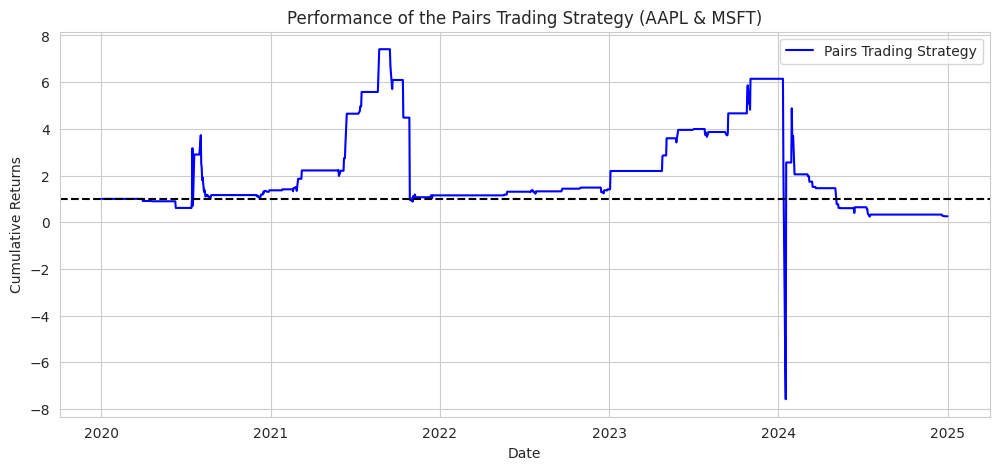

,Cumulative Returns
Date,
2020-01-02,NaN
2020-01-03,1.000000
2020-01-06,1.000000
2020-01-07,1.000000
2020-01-08,1.000000
...,...
2024-12-24,0.260041
2024-12-26,0.252496
2024-12-27,0.251528


In [50]:
# Backtest the strategy
pairs_trader.backtest_strategy()

## Evaluate Performance

Finally, we compute **risk-adjusted return metrics**:
- **Sharpe Ratio**
- **Max Drawdown**
- **Win Rate**

In [51]:
# Evaluate strategy performance
pairs_trader.evaluate_performance()

Sharpe Ratio: 0.02
Max Drawdown: -202.30%
Win Rate: 5.73%


(0.024793724993783513, -2.0230171743579426, 0.057279236276849645)

# Cointegration testing class

## Cointegration Testing Class

This class will:
- Accept a list of stock pairs.
- Fetch historical price data from Yahoo Finance.
- Compute the correlation between stock pairs.
- Perform the **Engle-Granger cointegration test**.
- Rank pairs based on their cointegration score.


In [57]:
class CointegrationTester:
    def __init__(self, stock_pairs, start_date="2020-01-01", end_date="2025-01-01"):
        """
        Initialize with a list of stock pairs and date range.
        """
        self.stock_pairs = stock_pairs
        self.start_date = start_date
        self.end_date = end_date
        self.results = []

    def fetch_data(self, stock):
        """
        Fetch historical adjusted closing prices for a given stock.
        """
        df = yf.download(stock, start=self.start_date, end=self.end_date)["Close"]
        return df

    def test_cointegration(self):
        """
        Perform the cointegration test for each stock pair and store results.
        """
        for stock_1, stock_2 in self.stock_pairs:
            print(f"Testing {stock_1} & {stock_2}...")

            # Fetch data
            df1 = self.fetch_data(stock_1)
            df2 = self.fetch_data(stock_2)
            # Convert df1 and df2 to Series explicitly if they are DataFrames
            df1 = df1.squeeze()  # Convert to Series if it's a DataFrame
            df2 = df2.squeeze()  # Convert to Series if it's a DataFrame

            # Merge into a single DataFrame
            data = pd.DataFrame({stock_1: df1, stock_2: df2}).dropna()

            # Calculate correlation
            correlation = data[stock_1].corr(data[stock_2])

            # Perform cointegration test
            score, p_value, _ = coint(data[stock_1], data[stock_2])

            # Store results
            self.results.append((stock_1, stock_2, correlation, p_value))

        # Convert results to DataFrame
        self.results_df = pd.DataFrame(self.results, columns=["Stock 1", "Stock 2", "Correlation", "Cointegration p-value"])
        self.results_df = self.results_df.sort_values(by="Cointegration p-value", ascending=True)
        return self.results_df

    def get_best_pair(self):
        """
        Return the best cointegrated stock pair.
        """
        best_pair = self.results_df.iloc[0][["Stock 1", "Stock 2"]].values
        return best_pair[0], best_pair[1]

    def display_results(self):
        """
        Display the best cointegrated stock pairs.
        """
        print("\nTop Cointegrated Stock Pairs:")
        print(self.results_df[self.results_df["Cointegration p-value"] < 0.05])

## Define Stock Pairs & Run Cointegration Test

We'll test **multiple stock pairs** from different sectors and rank them based on cointegration.


In [58]:
# Define stock pairs for testing
stock_pairs = [
    ("GS", "MS"),  # Goldman Sachs vs Morgan Stanley (Finance)
    ("JPM", "C"),  # JPMorgan Chase vs Citigroup (Finance)
    ("BAC", "WFC"),  # Bank of America vs Wells Fargo (Finance)
    ("AAPL", "MSFT"),  # Apple vs Microsoft (Tech)
    ("NVDA", "AMD"),  # NVIDIA vs AMD (Semiconductors)
    ("XOM", "CVX"),  # ExxonMobil vs Chevron (Energy)
    ("KO", "PEP"),  # Coca-Cola vs Pepsi (Consumer Staples)
    ("MCD", "SBUX"),  # McDonald's vs Starbucks (Retail)
    ("TSLA", "RIVN"),  # Tesla vs Rivian (Electric Vehicles)
    ("SPY", "VOO")  # S&P 500 ETF vs Vanguard S&P 500 ETF (ETFs)
]

# Instantiate the CointegrationTester class
cointegration_tester = CointegrationTester(stock_pairs)

# Run the test
results_df = cointegration_tester.test_cointegration()

# Display best pairs
cointegration_tester.display_results()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Testing GS & MS...
Testing JPM & C...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Testing BAC & WFC...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Testing AAPL & MSFT...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Testing NVDA & AMD...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Testing XOM & CVX...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Testing KO & PEP...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Testing MCD & SBUX...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Testing TSLA & RIVN...
Testing SPY & VOO...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Top Cointegrated Stock Pairs:
Empty DataFrame
Columns: [Stock 1, Stock 2, Correlation, Cointegration p-value]
Index: []


## Visualizing Cointegration Results

This chart shows the **p-values** of stock pairs.
- **Lower p-values** (< 0.05) indicate strong cointegration.
- **Higher p-values** suggest weak/no cointegration.


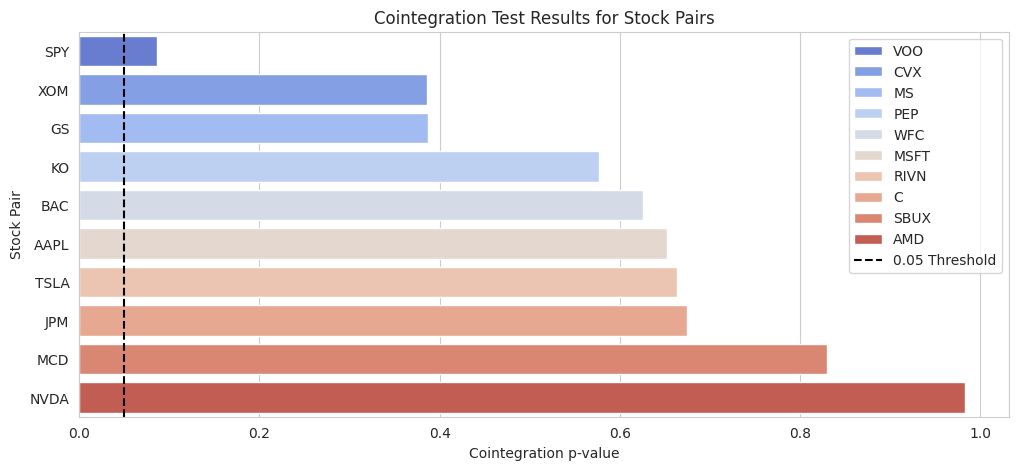

In [59]:
# Plot the results
plt.figure(figsize=(12, 5))
sns.barplot(x="Cointegration p-value", y="Stock 1", hue="Stock 2", data=results_df, palette="coolwarm")
plt.axvline(0.05, linestyle="--", color="black", label="0.05 Threshold")
plt.xlabel("Cointegration p-value")
plt.ylabel("Stock Pair")
plt.legend()
plt.title("Cointegration Test Results for Stock Pairs")
plt.show()

## Select the Best Cointegrated Pair

We choose the **pair with the lowest p-value** (strongest cointegration) for trading.


In [60]:
# Select the most cointegrated pair
best_pair = results_df.iloc[0][["Stock 1", "Stock 2"]].values
print(f"The best cointegrated pair is: {best_pair[0]} & {best_pair[1]}")

The best cointegrated pair is: SPY & VOO


## Run the Full Pipeline

1️⃣ Identify the **best cointegrated stock pair**  
2️⃣ Run **Pairs Trading Strategy** on the selected pair  
3️⃣ Backtest and evaluate performance  


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Testing GS & MS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Testing JPM & C...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Testing BAC & WFC...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Testing AAPL & MSFT...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Testing NVDA & AMD...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Testing XOM & CVX...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Testing KO & PEP...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Testing MCD & SBUX...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Testing TSLA & RIVN...
Testing SPY & VOO...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Best Pair for Trading: SPY & VOO



<ipython-input-45-776bfaf1ad07>:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self.hedge_ratio = model.params[1]


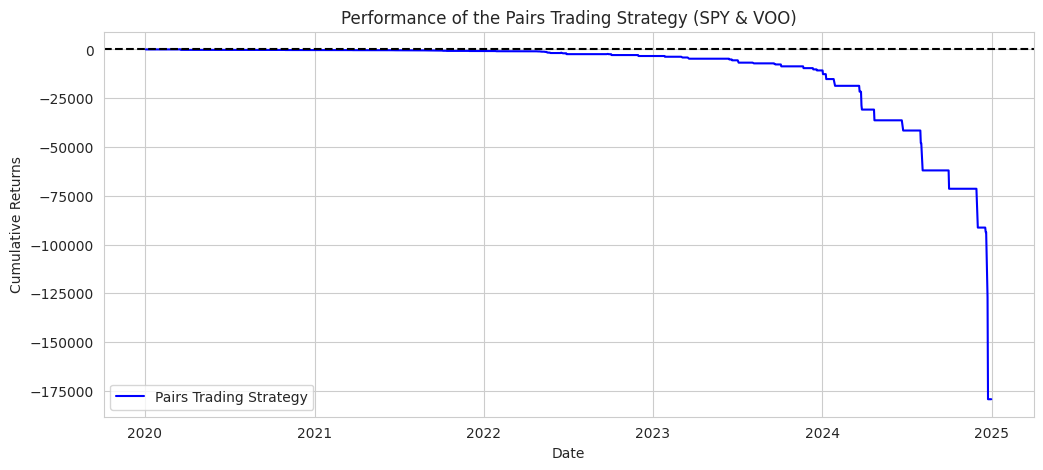

Sharpe Ratio: 0.47
Max Drawdown: -161855.06%
Win Rate: 5.73%


(0.46991470114728984, -1618.5505869060341, 0.057279236276849645)

In [61]:
# Define stock pairs
stock_pairs = [
    ("GS", "MS"),
    ("JPM", "C"),
    ("BAC", "WFC"),
    ("AAPL", "MSFT"),
    ("NVDA", "AMD"),
    ("XOM", "CVX"),
    ("KO", "PEP"),
    ("MCD", "SBUX"),
    ("TSLA", "RIVN"),
    ("SPY", "VOO")
]

# Instantiate the CointegrationTester class
cointegration_tester = CointegrationTester(stock_pairs)
results_df = cointegration_tester.test_cointegration()

# Get best cointegrated pair
best_stock_1, best_stock_2 = cointegration_tester.get_best_pair()
print(f"Best Pair for Trading: {best_stock_1} & {best_stock_2}")

# Run Pairs Trading Strategy
pairs_trader = PairsTradingStrategy(best_stock_1, best_stock_2)
pairs_trader.fetch_data()
pairs_trader.compute_spread_and_zscore()
pairs_trader.generate_trading_signals()
pairs_trader.backtest_strategy()
pairs_trader.evaluate_performance()

# Final Thoughts

This project implemented a **Pairs Trading strategy** using:
✅ **Cointegration analysis** to identify tradeable stock pairs.  
✅ **Statistical indicators (Z-score)** to generate trading signals.  
✅ **Backtesting framework** to assess strategy performance.  

Potential **future improvements** include:
- **Dynamic hedge ratio adjustment** using rolling regressions.
- **Machine learning-based signal generation** (e.g., Hidden Markov Models).
- **Real-time trading implementation** using broker APIs.
